In [1]:
from dataloader import CircleDataset, CircleRaw
from DETR_model import DinoDETR
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from polygon import RasLoss, SoftPolygon
from ModelInfer import ModelInfer

In [2]:
query_embed = nn.Embedding(80, 384)
query_embed.weight.shape

torch.Size([80, 384])

In [3]:
raw_set = CircleRaw()
data_set = CircleDataset()
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)

In [4]:
model = DinoDETR().cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
(
    pre_idx,
    fir_img,
    fir_sgm,
    fir_bou,
    pre_img,
    pre_sgm,
    pre_bou,
    cur_img,
    cur_sgm,
    cur_bou,
) = next(iter(data_loader))
pre_idx

tensor([0])

In [6]:
model_infer = ModelInfer(raw_set, is_detr=True)

In [7]:
model_infer.infer_model(model)

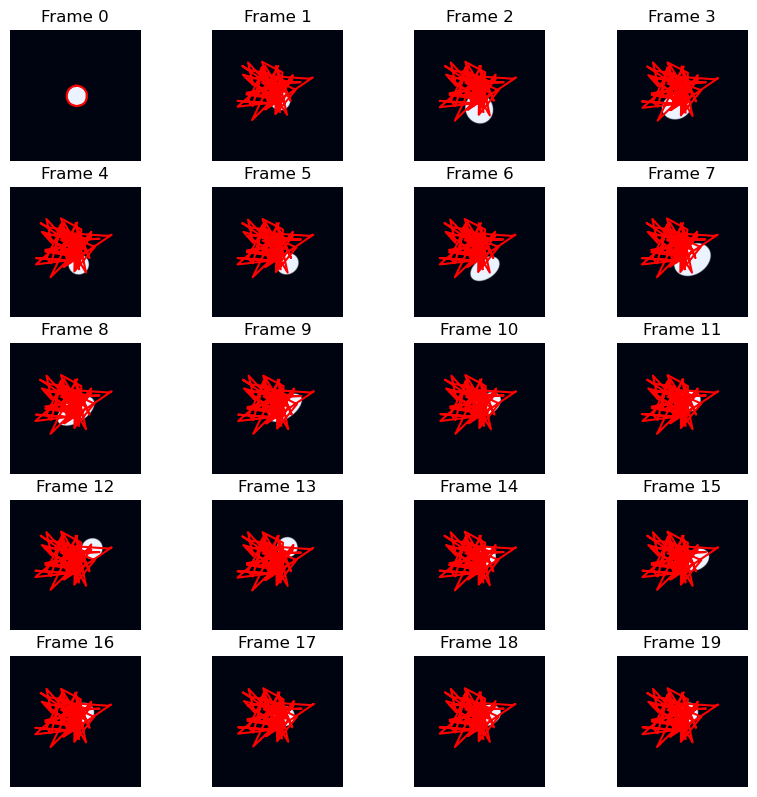

tensor(0.1849)

In [8]:
model_infer.show_infer_result(0)

In [9]:
model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
).shape

torch.Size([1, 80, 2])

In [10]:
model = DinoDETR().cuda()
ras_loss = RasLoss()
model_infer = ModelInfer(raw_set, is_detr=True)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [11]:
loss_dict = {}
iou_dict = {}
interval_epochs = 50
inter_num = 47
epoch_index = 0
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 0 Loss: 0.879623786399239
Epoch 1 Loss: 0.8535999122418856
Epoch 2 Loss: 0.8434768695580331
Epoch 3 Loss: 0.8176110543702778
Epoch 4 Loss: 0.8145209425374081
Epoch 5 Loss: 0.7727390214016563
Epoch 6 Loss: 0.7248310603593525
Epoch 7 Loss: 0.811896214359685
Epoch 8 Loss: 0.7651278815771404
Epoch 9 Loss: 0.7877192371769955
Epoch 10 Loss: 0.8170623967522069
Epoch 11 Loss: 0.7195212778292204
Epoch 12 Loss: 0.6774223446846008
Epoch 13 Loss: 0.6976376866039476
Epoch 14 Loss: 0.6845696882197732
Epoch 15 Loss: 0.832123875617981
Epoch 16 Loss: 0.6445294210785314
Epoch 17 Loss: 0.5928485205298976
Epoch 18 Loss: 0.705194005840703
Epoch 19 Loss: 0.6856606947748285
Epoch 20 Loss: 0.6364706754684448
Epoch 21 Loss: 0.5578870490977639
Epoch 22 Loss: 0.5036913909410176
Epoch 23 Loss: 0.5403681868001035
Epoch 24 Loss: 0.38833193088832657
Epoch 25 Loss: 0.47651310343491404
Epoch 26 Loss: 0.48615451549228866
Epoch 27 Loss: 0.38925832823703166
Epoch 28 Loss: 0.38709694147109985
Epoch 29 Loss: 0.362634

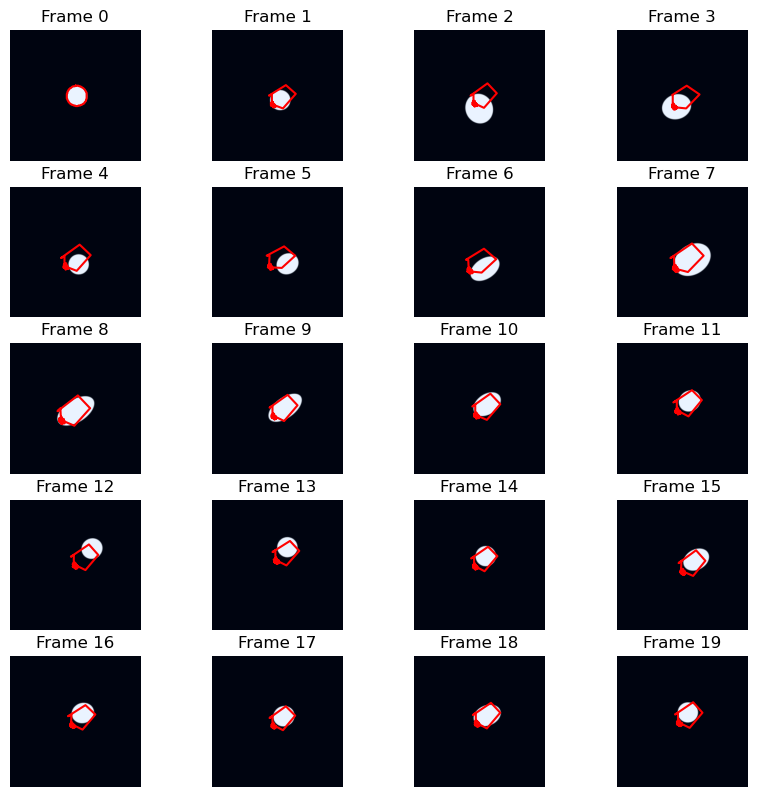

Epoch 50 Loss: 0.2627091972451461
Epoch 51 Loss: 0.33689147861380325
Epoch 52 Loss: 0.3396415522224025


KeyboardInterrupt: 

In [12]:
for interval in range(inter_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for (
            pre_idx,
            fir_img,
            fir_sgm,
            fir_bou,
            pre_img,
            pre_sgm,
            pre_bou,
            cur_img,
            cur_sgm,
            cur_bou,
        ) in data_loader:
            pre_idx = pre_idx.item()
            # pre_sgm = model_infer.get_segement(pre_idx)
            # pre_sgm = pre_sgm.unsqueeze(0)
            optimizer.zero_grad()
            pred_bou = model(
                fir_img.cuda(),
                fir_sgm.cuda(),
                pre_img.cuda(),
                pre_sgm.cuda(),
                cur_img.cuda(),
            )
            loss = ras_loss(pred_bou, cur_sgm.cuda())
            loss.backward()
            optimizer.step()
            mean_loss += loss.item()
        mean_loss /= len(data_loader)
        loss_dict[epoch_index] = mean_loss
        print(f"Epoch {epoch_index} Loss: {mean_loss}")
        epoch_index += 1
    model_infer.infer_model(model)
    total_iou = model_infer.get_infer_iou(0)
    iou_dict[epoch_index] = total_iou
    print(f"Epoch {epoch_index} IOU: {total_iou}")
    model_infer.show_infer_result(0)
    if interval_epochs > 50:
        interval_epochs = 50
        break
    if interval_epochs > 20:
        interval_epochs -= 10
            
            